# 医药电商数据销售分析

In [1]:
#导入基本的模块
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 设置Jupyter Notebook在运行时显示所有的输出结果，而不仅仅是最后一个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# 不显示警告
import warnings
warnings.filterwarnings('ignore')

In [132]:
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 12,8 #统一图片大小
sns.set_style('whitegrid') #统一图片样式
sns.set(font_scale=1.5) #统一图片字体

In [133]:
plt.rcParams['font.sans-serif'] = ['KaiTi'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

## 数据预处理

In [5]:
df = pd.read_excel("data.xlsx")
df.head()

,date_time,id,shop_name,title,sku_name,price,sold,discount,brand,parameter
0,2020-11-01,3985971101463,宜度海外专营店,特价处理！超低价19.9元起！含维生素ABCDE B族B12 维生素锌硒片,维生素e 300粒--买3送1,60.900000,19,9折,NaN,厂名:Puritan's Pride||品牌:Puritan‘s Pride/普丽普莱||生...
1,2020-11-01,4224064440294,天猫国际进口超市,FANCL男40岁综合营养包30包/袋*2复合多种维生素日本芳珂fancl,(【直营】日本FANCL/芳珂 40岁男性综合维生素营养 30袋（30天量）)*2,500.000000,71,9折,NaN,品牌:FANCL||系列:综合营养包||生产企业:FANCL株式会社
2,2021-12-01,3437759489038,阿里健康大药房,民生21金维他多维元素片30片儿童男女成人补充维生素矿物质缺乏,国民大牌| 补充21种维矿,22.416667,366,9.5折,NaN,产品名称:21金维他 多维元素片（21） 30片*1瓶/盒||药品通用名:多维元素片（21）...
3,2021-12-01,576002931540,天猫国际进口超市,【直营】美国进口安利简装倍立健多种复合维生素矿物质营养186片,NaN,452.250000,28,9.5折,NaN,厂名:Amway Dominican Republic LLC||生产企业:Amway||系...
4,2021-03-01,4363644898037,阿里健康大药房,买2送礼】elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方,爱乐维玛咖锌淫羊藿胶囊140粒+爱乐维 复合维生素片30片/盒,371.666667,32,9折,NaN,品牌:elevit/爱乐维||药品名称:复合维生素片||药品通用名:复合维生素片||生产企业...


In [6]:
df.dtypes #数据类型
df.shape #数据大小
df.isnull().sum(axis=0) #空值情况
df.duplicated().sum(axis=0) #重复情况

date_time    datetime64[ns]
id                    int64
shop_name            object
title                object
sku_name             object
price               float64
sold                  int64
discount             object
brand                object
parameter            object
dtype: object

(75110, 10)

date_time        0
id               0
shop_name        0
title            0
sku_name     41825
price            0
sold             0
discount      2884
brand        51166
parameter     2552
dtype: int64

0

<AxesSubplot:>

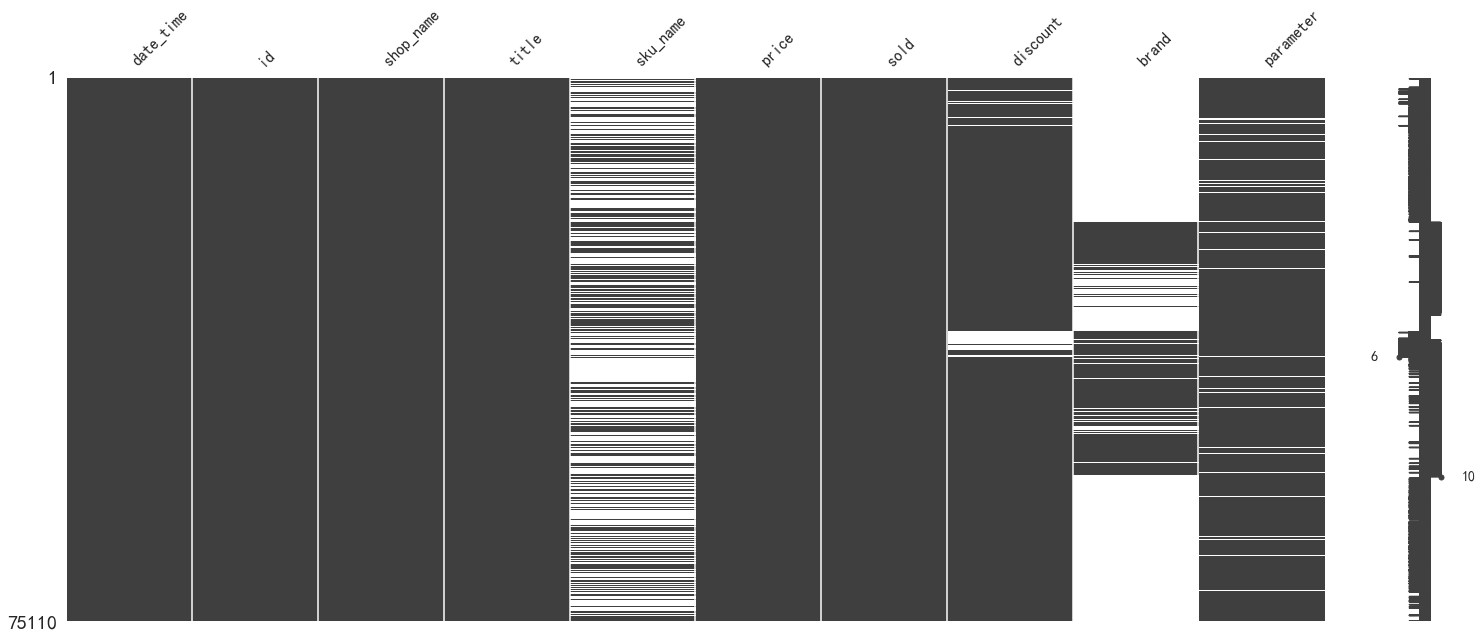

In [7]:
#可视化空值
import missingno as msno
msno.matrix(df)

- 删除id
- 将price，sold和discount合并成一列（销售额）
- 将parameter分开并提取信息
- 从title 和 skuname 中找到更多信息

In [8]:
df = df.drop("id",axis=1) #删除id列

In [9]:
#销售额计算
df['discount_number'] = df['discount'].apply(
    lambda x: float(re.findall(r'-?\d+\.?\d*e?-?\d*?',str(x))[0]) if len(re.findall(r'-?\d+\.?\d*e?-?\d*?',str(x)))!=0 else 10
) #提取数字，如果空值默认不打折（返回10）

df['sale_total'] = df['price']*df['sold']*df['discount_number']*0.1

In [10]:
df.parameter[3].split('||')

['厂名:Amway Dominican Republic LLC', '生产企业:Amway', '系列:倍立健', '品牌:AMWAY/安利']

In [11]:
content = [df.parameter[1].split('||')[i].split(':')[0] for i in range(len(df.parameter[1].split('||')))]

In [12]:
content = list(set(content))

In [13]:
content

['生产企业', '系列', '品牌']

In [14]:
#找到parameter中所有可能含有的信息
content = []
for i in range(len(df.parameter)):
    #一条记录所含的content
    splitted = str(df.parameter[i]).split('||')
    content.extend( [splitted[j].strip().split(':')[0] for j in range(len(splitted))] )

content = list(set(content))#去重
print(content)

['生产企业', '系列', '药品名称', '产品名称', 'nan', '药品通用名', '药品规格', '规格', '药品商品名', '品牌', '厂名', '品名']


可以总结为四个features：
- 品类：'药品名称', '品名', '药品商品名', '产品名称', '药品通用名', '系列'
- 品牌：'品牌'（加上本来就有的brand column）
- 厂商：'厂名', '生产企业'
- 规格： '药品规格', '规格'

缺失信息可以从title 和sku_name里面找


In [15]:
def find_information(feature,x):
    
    #feature 输入上面四个feature中的一个
    #x：要从中找信息的字段
   
    if feature == '品类':
        feature = [ '药品通用名','药品名称', '品名', '药品商品名', '产品名称', '系列']
    elif feature == '品牌':
        feature == ['品牌']
    elif feature == '厂商':
        feature = ['厂名', '生产企业']
    elif feature == '规格':
        feature = ['药品规格', '规格']
        
    splitted = str(x).split('||')
    info = []
    for i in range(len(splitted)):
        if splitted[i].split(':')[0] in feature:
            info.append(splitted[i].split(':')[1])
    info = list(set(info)) #去重
    if len(info) != 0:
        return info[0]
    else:
        return None

In [16]:
find_information(x = df.parameter[3], feature = '品牌') #example

'AMWAY/安利'

In [17]:
product,brand,factory,size = [],[],[],[]
for i in range(df.shape[0]):
    product.append(find_information(x = df.parameter[i], feature = '品类'))
    brand.append(find_information(x = df.parameter[i], feature = '品牌'))
    factory.append(find_information(x = df.parameter[i], feature = '厂商'))
    size.append(find_information(x = df.parameter[i], feature = '规格'))

In [18]:
df['品类'],df['品牌'],df['厂商'],df['规格'] = product,brand,factory,size

In [19]:
df = df.drop("parameter",axis=1) #删除parameter列
df = df.drop("discount",axis=1) #删除discount列

In [20]:
df.isnull().sum(axis=0)

date_time              0
shop_name              0
title                  0
sku_name           41825
price                  0
sold                   0
brand              51166
discount_number        0
sale_total             0
品类                  6201
品牌                  2552
厂商                  7842
规格                 59765
dtype: int64

In [21]:
#用brand填补缺失的品牌
df['品牌'].fillna(df['brand'],inplace = True)
df = df.drop('brand',axis=1)

In [22]:
#找到用不同品牌名的同一品牌
brands = df['品牌'].dropna().unique()
b= [] #重复的品牌
for i in range(len(brands)-1):
    for j in range(int(i+1),len(brands)):
        if brands[i] in brands[j]:
            b.append([brands[i],brands[j]])
        if brands[j] in brands[i]:
            b.append([brands[j],brands[i]])

b

[['FANCL', 'FANCL HealthScience'],
 ['汤臣倍健', 'BY－HEALTH/汤臣倍健'],
 ['朗迪', '精朗迪'],
 ['ON', 'CONBA/康恩贝'],
 ['仁和', '药都仁和'],
 ['Ostelin', 'Ostelin/奥斯特林'],
 ['贝特令', '金贝特令'],
 ['Nature Made', 'Nature Made/天维美'],
 ['OPPULAND', 'OPPULAND/欧普兰'],
 ['Vitafusion', 'Vitafusion Vitafusion'],
 ['ON', 'FOR BECARED ONE'],
 ['江中', '江中制药'],
 ['ON', 'SWANSON'],
 ['POLA', 'POLA/宝丽'],
 ["Doctor's Best", "Doctor's Best/迪佰特"],
 ['ON', 'CHENPON'],
 ["Nature's Way", "Nature's Way（澳大利亚）"],
 ['Orthomol', 'Orthomol/奥适宝'],
 ['ON', 'ONAKA'],
 ['KAL', 'KAL/凯雷澳'],
 ['盖中盖', '新盖中盖'],
 ['哈药', '哈药六'],
 ['禾博士', 'Dr．Herbs/禾博士'],
 ['Healthy Origins', 'Healthy Origins（保健品）'],
 ['KAL', 'UNIKALK'],
 ['悦康', '悦康维'],
 ['ON', 'AVALON（新加坡）'],
 ['HUM', 'HUM（保健品）'],
 ['ON', 'NUTRITION29'],
 ['ON', 'MASON NATURAL'],
 ['Osteo', 'Osteo Bi-Flex']]

In [23]:
#删除第一个是on的元素
on = []
for i in range(len(b)):
    if b[i][0] == 'ON':
        on.append(b[i])

for j in on:
    b.remove(j)

In [24]:
b.remove(['朗迪', '精朗迪'])

In [25]:
b.remove( ['KAL', 'UNIKALK'])

In [26]:
b_dict = dict(zip([b[i][1] for i in range(len(b))],[b[i][0] for i in range(len(b))]))
b_dict

{'FANCL HealthScience': 'FANCL',
 'BY－HEALTH/汤臣倍健': '汤臣倍健',
 '药都仁和': '仁和',
 'Ostelin/奥斯特林': 'Ostelin',
 '金贝特令': '贝特令',
 'Nature Made/天维美': 'Nature Made',
 'OPPULAND/欧普兰': 'OPPULAND',
 'Vitafusion Vitafusion': 'Vitafusion',
 '江中制药': '江中',
 'POLA/宝丽': 'POLA',
 "Doctor's Best/迪佰特": "Doctor's Best",
 "Nature's Way（澳大利亚）": "Nature's Way",
 'Orthomol/奥适宝': 'Orthomol',
 'KAL/凯雷澳': 'KAL',
 '新盖中盖': '盖中盖',
 '哈药六': '哈药',
 'Dr．Herbs/禾博士': '禾博士',
 'Healthy Origins（保健品）': 'Healthy Origins',
 '悦康维': '悦康',
 'HUM（保健品）': 'HUM',
 'Osteo Bi-Flex': 'Osteo'}

In [27]:
df = df.replace(b_dict)
'哈药六' in list(df['品牌'])

False

In [28]:
re.sub('[^\u4E00-\u9FD5,a-z,A-Z./*0-9]+', ' ',df.title[1]) #提取有用信息

'FANCL男40岁综合营养包30包/袋*2复合多种维生素日本芳珂fancl'

In [29]:
#将title 和 sku_name 中有用的文字部分重新整合
new_title = [df.title[i]+df.sku_name[i] if type(df.sku_name[i])==str else df.title[i] for i in range(len(df.title))]
#品类中也会有规格信息
new_title = [new_title[i]+df['品类'][i] if type(df['品类'][i])==str else new_title[i] for i in range(len(df.title))]
df['new_title'] = new_title

#删除new-title中没有用的部分
df['new_title'] = df['new_title'].apply(
    lambda x: re.sub('[^\u4E00-\u9FD5,a-z,A-Z./*0-9]+', ' ', x) #用空格替代？
)


In [30]:
df['new_title']

0        特价处理 超低价19.9元起 含维生素ABCDE B族B12 维生素锌硒片维生素e 300粒...
1        FANCL男40岁综合营养包30包/袋*2复合多种维生素日本芳珂fancl 直营 日本FAN...
2        民生21金维他多维元素片30片儿童男女成人补充维生素矿物质缺乏国民大牌 补充21种维矿21金...
3                        直营 美国进口安利简装倍立健多种复合维生素矿物质营养186片倍立健
4        买2送礼 elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方爱乐维玛咖锌淫羊藿胶囊...
                               ...                        
75105        恒健维生素C片VC 维C100片补充维生素C妊娠呕吐发少发黄vc片药用标准装1盒维生素C片
75106               日本参天维生素B12 E眼药水*12ml 滴眼液 缓解眼疲劳 眼疾预防滴眼液
75107         3倍购买 美国GNC综合营养包30天套装 含钙片/DHA/维生素维生素矿物质精华 孕妇 
75108    星鲨维生素E软胶囊100mg*60粒/盒心脑血管疾病 流产 不孕症本品5盒 优惠装 节省2....
75109    力生 复合维生素B片100片/盒 维生素缺乏症脚气矿物质缺乏症厌食标准装力生 复合维生素B片...
Name: new_title, Length: 75110, dtype: object

In [31]:
#从 title和sku_name 找到规格
pattern = re.compile(r"[\d+]+[\u4E00-\u9FD5]+/[\u4E00-\u9FD5]")
df['size']  = df['new_title'].apply(
    lambda x: re.findall(pattern,x)[0] if len(re.findall(pattern,x))!=0 else None
)

In [32]:
df['规格'].fillna(df['size'],inplace = True)
df = df.drop('size',axis=1)

In [33]:
#从 title和sku_name 找到性别
df['性别'] = df['new_title'].apply(
    lambda x: '通用' if '男女' in x else '男性' if '男' in x else '女性'  if '女' in x  else '女性'  if '孕妇' in x else '通用'
)

In [34]:
#从 title 和 sku_name 中找到是否为复合维生素
p = re.compile(r"['维生素']+[a-e,A-E]+")
df['复合'] = df['new_title'].apply(
    lambda x: 1 if ('复合' in x) or ('综合'in x) or ('多维'in x) or ('维生素ABCDE' in re.findall(p,x)) else 0
)

df = df.drop('new_title',axis=1)

In [35]:
#新增加一栏title中是否有推荐/同款
df['推荐/同款'] = df['title'].apply(
    lambda x : 1 if ('推荐' in x) or ('同款' in x) else 0
)

In [36]:
df.head()

,date_time,shop_name,title,sku_name,price,sold,discount_number,sale_total,品类,品牌,厂商,规格,性别,复合,推荐/同款
0,2020-11-01,宜度海外专营店,特价处理！超低价19.9元起！含维生素ABCDE B族B12 维生素锌硒片,维生素e 300粒--买3送1,60.900000,19,9.0,1041.390,综合系列,Puritan‘s Pride/普丽普莱,Puritan's Pride,None,通用,1,0
1,2020-11-01,天猫国际进口超市,FANCL男40岁综合营养包30包/袋*2复合多种维生素日本芳珂fancl,(【直营】日本FANCL/芳珂 40岁男性综合维生素营养 30袋（30天量）)*2,500.000000,71,9.0,31950.000,综合营养包,FANCL,FANCL株式会社,30包/袋,男性,1,0
2,2021-12-01,阿里健康大药房,民生21金维他多维元素片30片儿童男女成人补充维生素矿物质缺乏,国民大牌| 补充21种维矿,22.416667,366,9.5,7794.275,21金维他 多维元素片（21） 30片*1瓶/盒,21金维他,杭州赛诺菲民生健康药业有限公司,30片*1瓶/盒,通用,1,0
3,2021-12-01,天猫国际进口超市,【直营】美国进口安利简装倍立健多种复合维生素矿物质营养186片,NaN,452.250000,28,9.5,12029.850,倍立健,AMWAY/安利,Amway Dominican Republic LLC,None,通用,1,0
4,2021-03-01,阿里健康大药房,买2送礼】elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方,爱乐维玛咖锌淫羊藿胶囊140粒+爱乐维 复合维生素片30片/盒,371.666667,32,9.0,10704.000,复合维生素片,elevit/爱乐维,拜耳医药保健有限公司,30片/盒,通用,1,0


In [37]:
df = df.drop(df[df.price > 4000].index,axis=0) #删除异常值

还可以研究的指标：老年儿童青年，疾病种类，孕妇或者其他特殊人群 (以销售额为weight绘制词云）

SKU泛滥对需求预测、供应链管理的挑战。SKU是英语中StockKeeping Unit的缩写，直译过来就是存货单元。

In [38]:
#最终数据集展现
data = df.copy()
data.columns = [['日期','店铺','标题','SKU','单价','销量','折扣','销售额','品类','品牌','厂商','规格','性别','复合','推荐/同款']]
data.head()

,日期,店铺,标题,SKU,单价,销量,折扣,销售额,品类,品牌,厂商,规格,性别,复合,推荐/同款
0,2020-11-01,宜度海外专营店,特价处理！超低价19.9元起！含维生素ABCDE B族B12 维生素锌硒片,维生素e 300粒--买3送1,60.900000,19,9.0,1041.390,综合系列,Puritan‘s Pride/普丽普莱,Puritan's Pride,None,通用,1,0
1,2020-11-01,天猫国际进口超市,FANCL男40岁综合营养包30包/袋*2复合多种维生素日本芳珂fancl,(【直营】日本FANCL/芳珂 40岁男性综合维生素营养 30袋（30天量）)*2,500.000000,71,9.0,31950.000,综合营养包,FANCL,FANCL株式会社,30包/袋,男性,1,0
2,2021-12-01,阿里健康大药房,民生21金维他多维元素片30片儿童男女成人补充维生素矿物质缺乏,国民大牌| 补充21种维矿,22.416667,366,9.5,7794.275,21金维他 多维元素片（21） 30片*1瓶/盒,21金维他,杭州赛诺菲民生健康药业有限公司,30片*1瓶/盒,通用,1,0
3,2021-12-01,天猫国际进口超市,【直营】美国进口安利简装倍立健多种复合维生素矿物质营养186片,NaN,452.250000,28,9.5,12029.850,倍立健,AMWAY/安利,Amway Dominican Republic LLC,None,通用,1,0
4,2021-03-01,阿里健康大药房,买2送礼】elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方,爱乐维玛咖锌淫羊藿胶囊140粒+爱乐维 复合维生素片30片/盒,371.666667,32,9.0,10704.000,复合维生素片,elevit/爱乐维,拜耳医药保健有限公司,30片/盒,通用,1,0


In [39]:
data.isnull().sum(axis=0)

日期           0
店铺           0
标题           0
SKU      41824
单价           0
销量           0
折扣           0
销售额          0
品类        6201
品牌        1653
厂商        7842
规格       56229
性别           0
复合           0
推荐/同款        0
dtype: int64

In [40]:
data.describe()

,单价,销量,折扣,销售额,复合,推荐/同款
count,75109.000000,75109.000000,75109.000000,7.510900e+04,75109.000000,75109.00000
mean,132.068621,240.975609,9.187368,1.997643e+04,0.270500,0.00904
std,116.312448,1384.213009,0.379572,1.296523e+05,0.444221,0.09465
min,1.010000,0.000000,8.500000,0.000000e+00,0.000000,0.00000
25%,57.000000,2.000000,9.000000,2.430000e+02,0.000000,0.00000
50%,107.000000,11.000000,9.000000,9.880000e+02,0.000000,0.00000
75%,169.000000,70.000000,9.500000,5.838750e+03,1.000000,0.00000
max,1789.000000,103940.000000,10.000000,9.978240e+06,1.000000,1.00000


## 店铺分析

In [41]:
df.shop_name.unique()
len(df.shop_name.unique()) #number

array(['宜度海外专营店', '天猫国际进口超市', '阿里健康大药房', '天猫国际妙颜社', '天猫超市', '百康保健品专营店',
       'ChemistWarehouse海外旗舰店', '阿里健康大药房海外店', '康恩贝官方旗舰店', '百秀大药房旗舰店',
       'nyc美林健康海外专营店', '康爱多大药房旗舰店', 'NRC营养优选海外专营店', 'skyshop海外专营店',
       '苏宁易购官方旗舰店', 'hihealth海外专营店', 'nrfs湖畔海外专营店', '康寿营养品店',
       '焦作国控大药房旗舰店', 'thejamy保健海外专营店', '美加精品', '搬运健康馆',
       'LuckyVitamin海外旗舰店', '同堂保健品专营店', '进口/国产保健品精品店', 'SASA美国直邮'],
      dtype=object)

26

In [42]:
#计算每个店铺的销售额和销售占比
shops = pd.DataFrame(df.groupby(by='shop_name')['sale_total'].sum()).sort_values('sale_total',ascending=False).reset_index()
shops['proportion'] = shops['sale_total']/sum(shops['sale_total'])
shops

,shop_name,sale_total,proportion
0,阿里健康大药房,6.751027e+08,0.449946
1,天猫国际进口超市,3.561012e+08,0.237336
2,天猫超市,1.148217e+08,0.076527
3,阿里健康大药房海外店,1.065089e+08,0.070987
4,康恩贝官方旗舰店,9.559872e+07,0.063715
5,ChemistWarehouse海外旗舰店,5.539680e+07,0.036921
6,天猫国际妙颜社,3.569804e+07,0.023792
7,苏宁易购官方旗舰店,1.065959e+07,0.007104
8,thejamy保健海外专营店,9.798825e+06,0.006531
9,skyshop海外专营店,6.506159e+06,0.004336


([<matplotlib.patches.Wedge at 0x277e55e67f0>,
 [Text(0.1722633879494899, 1.0864277818484593, '阿里健康大药房'),
  Text(-0.9993516026357361, -0.4596698536008056, '天猫国际进口超市'),
  Text(-0.16835557213502222, -1.0870402022607488, '天猫超市'),
  Text(0.3353264452976463, -1.0476431525495906, '阿里健康大药房海外店'),
  Text(0.7359718376086659, -0.8175239777810334, '康恩贝官方旗舰店'),
  Text(1.0445597090235936, -0.3448115634437827, '其他')],
 [Text(0.09396184797244903, 0.5925969719173414, '45%'),
  Text(-0.5451008741649469, -0.25072901105498485, '24%'),
  Text(-0.09183031207364849, -0.5929310194149539, '8%'),
  Text(0.18290533379871618, -0.5714417195725039, '7%'),
  Text(0.40143918415018137, -0.44592216969874543, '6%'),
  Text(0.5697598412855964, -0.18807903460569964, '10%')])

Text(0.5, 1.0, '各店铺总销售额占比')

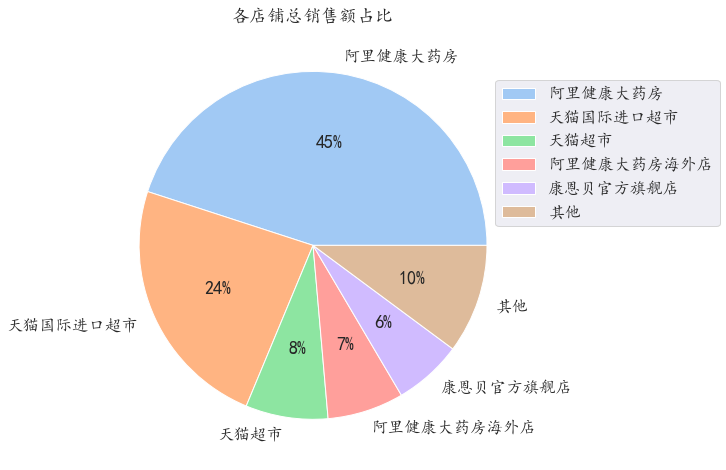

In [43]:
#总销售额饼图
#define data
data = list(shops.sale_total[0:5])
data.append(shops.sale_total.sum()-shops.sale_total[0:5].sum())
labels = list(shops.shop_name[0:5])
labels.append('其他')

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:6]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.legend(loc ='upper left',bbox_to_anchor=(0.9,0.9))
plt.title('各店铺总销售额占比')
plt.show()

In [44]:
#只含阿里健康大药房的数据
data_1 = df[df.shop_name == '阿里健康大药房'].drop(['shop_name'],axis=1).reset_index(drop=True)
data_1.head()

,date_time,title,sku_name,price,sold,discount_number,sale_total,品类,品牌,厂商,规格,性别,复合,推荐/同款
0,2021-12-01,民生21金维他多维元素片30片儿童男女成人补充维生素矿物质缺乏,国民大牌| 补充21种维矿,22.416667,366,9.5,7794.275,21金维他 多维元素片（21） 30片*1瓶/盒,21金维他,杭州赛诺菲民生健康药业有限公司,30片*1瓶/盒,通用,1,0
1,2021-03-01,买2送礼】elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方,爱乐维玛咖锌淫羊藿胶囊140粒+爱乐维 复合维生素片30片/盒,371.666667,32,9.0,10704.000,复合维生素片,elevit/爱乐维,拜耳医药保健有限公司,30片/盒,通用,1,0
2,2020-06-01,朗迪碳酸钙D3片100片孕妇哺乳儿童钙片中老年人维生素D咀嚼补钙片,【1盒装】,119.000000,6425,9.0,688117.500,朗迪 碳酸钙D3片(II) 100片*1瓶/盒,朗迪,北京康远制药有限公司,100片*1瓶/盒,女性,0,0
3,2021-12-01,惠氏玛特纳复合维生素孕妇型叶酸片备孕期孕妇专用天猫备孕孕早期,100片装惠氏多维片,376.428571,70,9.5,25032.500,MATERNA 多种维生素矿物质片（孕妇乳母）,曼多能,仙乐健康科技股份有限公司,None,女性,1,0
4,2021-09-01,汤臣倍健维生素b族片复合维生素b2b6b12vb维b综合b男女性维他命,标准装,60.000000,7416,9.0,400464.000,维生素B族片,汤臣倍健,汤臣倍健股份有限公司,None,通用,1,0


In [45]:
data_1.isnull().sum(axis=0)
data_1.shape

date_time             0
title                 0
sku_name           3045
price                 0
sold                  0
discount_number       0
sale_total            0
品类                   17
品牌                    6
厂商                    7
规格                 4077
性别                    0
复合                    0
推荐/同款                 0
dtype: int64

(16958, 14)

In [46]:
data_1.describe()

,price,sold,discount_number,sale_total,复合,推荐/同款
count,16958.000000,16958.000000,16958.000000,1.695800e+04,16958.000000,16958.000000
mean,92.668085,551.286296,9.339663,3.981028e+04,0.164760,0.000354
std,91.857052,2169.318065,0.301560,2.045990e+05,0.370975,0.018807
min,2.900000,0.000000,8.500000,0.000000e+00,0.000000,0.000000
25%,28.900000,15.000000,9.000000,8.660475e+02,0.000000,0.000000
50%,69.000000,72.000000,9.500000,3.648879e+03,0.000000,0.000000
75%,124.000000,339.000000,9.500000,1.763485e+04,0.000000,0.000000
max,1123.060000,103940.000000,10.000000,9.978240e+06,1.000000,1.000000


In [47]:
#number of products
len(data_1.title.unique())
len(data_1.品牌.unique())
len(data_1.品类.unique())

1663

192

444

In [48]:
#品牌
data_1_brand = pd.DataFrame(data_1.groupby('品牌')['sale_total'].sum()).sort_values('sale_total',ascending=False)
data_1_brand['proportion'] = data_1_brand['sale_total']/sum(shops['sale_total'])
data_1_brand.head()

,sale_total,proportion
品牌,,
星鲨,9.763598e+07,0.065073
elevit/爱乐维,8.885302e+07,0.059219
伊可新,5.961078e+07,0.039730
CENTRUM/善存,4.668703e+07,0.031116
养生堂,3.636749e+07,0.024238


In [49]:
data_1[data_1['品牌']=='星鲨']['品类'].unique()

array(['星鲨 维生素E软胶囊 100mg*60粒/盒', '三维鱼肝油乳', '维生素AD软胶囊', '维生素D滴剂（胶囊型）',
       '星鲨 维生素D滴剂（胶囊型） 400单位*30粒/盒', '维生素AD滴剂(胶囊型)',
       '星鲨 维生素AD滴剂 15ml*1瓶/盒', '星鲨 鱼肝油乳 500ML*1瓶/盒',
       '星鲨 维生素E软胶囊 100mg*30粒/盒', '维生素E软胶囊(天然型)', '维生素E软胶囊'], dtype=object)

In [50]:
data_1[data_1['品牌']=='elevit/爱乐维']['品类'].unique()

array(['复合维生素片', '多种维生素矿物质片（乳母型）', '爱乐维'], dtype=object)

In [51]:
data_1[data_1['品牌']=='伊可新']['品类'].unique()

array(['维生素AD滴剂(胶囊型)', '伊可新 伊可新 维生素AD滴剂（胶囊型） 50粒/盒', '伊可新 维生素AD滴剂(胶囊型)',
       '伊可新 维生素AD滴剂（胶囊型）'], dtype=object)

array([<AxesSubplot:xlabel='date_time'>, <AxesSubplot:xlabel='date_time'>],
      dtype=object)

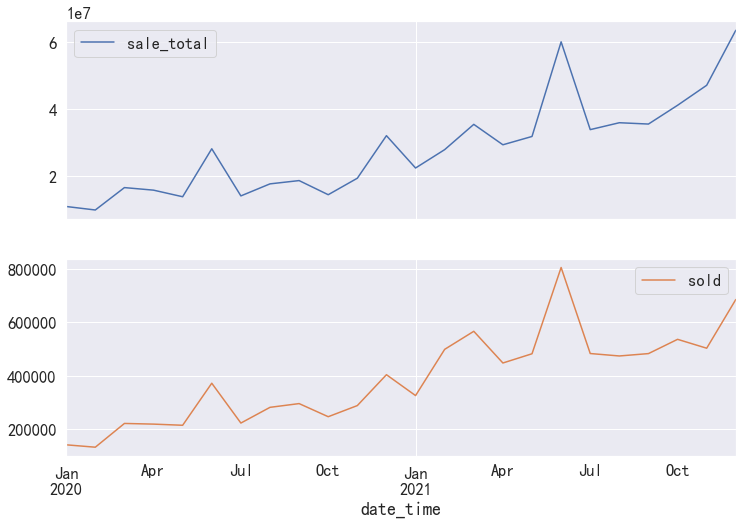

In [52]:
#销售额和销售量随月份变化图
plt.rcParams['figure.figsize'] = (12.0, 8.0)
data_1_monthly = pd.DataFrame(data_1.groupby('date_time')[['sale_total','sold']].sum())
data_1_monthly.plot(subplots=True)

In [53]:
#2021-06 销量最高的十个商品
data_1[data_1.date_time == '2021-06-01'].sort_values('sale_total',ascending = False)['title'][0:10] 

7099          3盒】星鲨维生素D滴剂(胶囊型)24粒补钙维生素D佝偻病官方婴儿钙
5639            领券减】爱乐维复合维生素100片孕妇叶酸补充备孕早期多维元素B
10279           朗迪钙碳酸钙D3颗粒维生素d孕妇儿童补钙小儿钙青少年OTC钙片
253          3盒】星鲨维生素D滴剂(胶囊型)36粒预防补钙佝偻病婴幼儿童鲨星d3
7407          星鲨维生素D滴剂(胶囊型)30粒儿童补钙补充维生素D发育迟缓佝偻病
8731           惠氏钙尔奇钙片60片碳酸钙D3孕妇成人补钙维生素D3骨质疏松药店
459         3盒包邮】达因伊可新维生素AD滴剂30粒1岁以上AD预防佝偻病ad滴剂
7617          丽点维A酸乳膏20g去闭口粉刺暗疮软膏维生素a维a乳酸膏乳软膏祛痘
12374    21金维他多维元素片100片复合维生素B b6 b1 b2维生素c钙铁锌21
16783      200天】养生堂天然维生素E软胶囊200粒VE正品祛斑美容搭VC维生素c
Name: title, dtype: object

In [54]:
#与总体销量较高的商品对比
data_1_product = pd.DataFrame(data_1.groupby(by='title')['sale_total'].sum()).sort_values('sale_total',ascending=False).reset_index()
data_1_product['proportion'] = data_1_product['sale_total']/sum(shops['sale_total'])
data_1_product.head(10).title

0           领券减】爱乐维复合维生素100片孕妇叶酸补充备孕早期多维元素B
1         3盒】星鲨维生素D滴剂(胶囊型)24粒补钙维生素D佝偻病官方婴儿钙
2       3盒包邮】达因伊可新维生素AD滴剂30粒1岁以上AD预防佝偻病ad滴剂
3        3盒】星鲨维生素D滴剂(胶囊型)24粒补钙维生素D3佝偻病官方婴儿钙
4    21金维他多维元素片100片复合维生素B b6 b1 b2维生素c钙铁锌21
5        达因伊可新维生素AD滴剂50粒0~1岁维生素儿童婴幼儿婴儿钙ad滴剂
6           【3盒装】星鲨维生素D滴剂(胶囊型)24粒补钙维生素D 佝偻病
7          惠氏钙尔奇钙片60片碳酸钙D3孕妇成人补钙维生素D3骨质疏松药店
8         丽点维A酸乳膏20g去闭口粉刺暗疮软膏维生素a维a乳酸膏乳软膏祛痘
9         星鲨维生素D滴剂(胶囊型)30粒儿童补钙补充维生素D发育迟缓佝偻病
Name: title, dtype: object

[Text(0.5, 1.0, '通用')]

[(2.0, 17.0)]

[Text(0.5, 1.0, '女性')]

[(2.0, 17.0)]

[Text(0.5, 1.0, '男性')]

[(2.0, 17.0)]

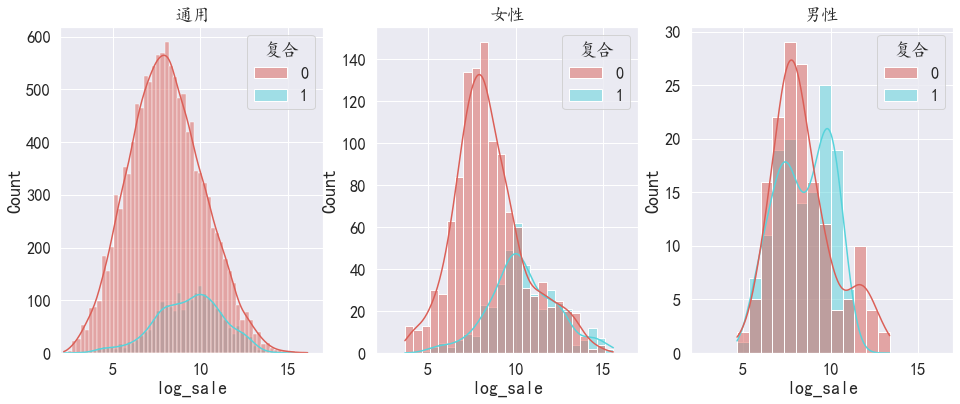

In [55]:
#性别和复合
data_1['log_sale'] = np.log(data_1['sale_total'])
fig,axes=plt.subplots(1,3,figsize = (16,6))
for i, sex in enumerate(data_1['性别'].unique()):
    sns.histplot(data_1[data_1['性别']==sex], x='log_sale', hue="复合", kde=True,ax = axes[i],palette='hls').set(title=sex)
    axes[i].set(xlim=(2, 17))

In [57]:
#Two-Sample Kolmogorov-Smirnov Test
from scipy.stats import ks_2samp
for sex in list(data_1['性别'].unique()):
    print(sex)
    Data = data_1[data_1['性别']==sex]
    ks_2samp(data1=Data[Data['复合']==1]['sale_total'],data2 = Data[Data['复合']==0]['sale_total'])

通用


KstestResult(statistic=0.2809486774463825, pvalue=3.833828835748192e-133)

女性


KstestResult(statistic=0.4585484059672369, pvalue=2.7755575615628914e-15)

男性


KstestResult(statistic=0.16195847947672765, pvalue=0.038266564902747824)

[Text(0.5, 1.0, '通用')]

[(2.0, 17.0)]

[Text(0.5, 1.0, '女性')]

[(2.0, 17.0)]

[Text(0.5, 1.0, '男性')]

[(2.0, 17.0)]

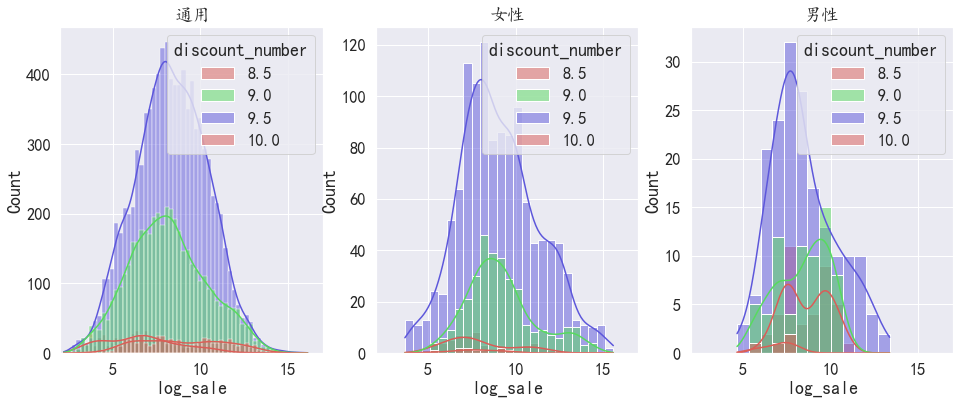

In [58]:
#性别和复合
fig,axes=plt.subplots(1,3,figsize = (16,6))
for i, sex in enumerate(data_1['性别'].unique()):
    sns.histplot(data_1[data_1['性别']==sex], x='log_sale', hue="discount_number", kde=True,ax = axes[i],palette='hls').set(title=sex)
    axes[i].set(xlim=(2, 17))

In [59]:
#title 词云
import jieba
import itertools
from wordcloud import WordCloud

with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stop = f.read()
stop = stop.split()
stop = [' ','片','粒','瓶','盒'] + stop

In [60]:
data_cut = data_1['title'].apply(jieba.lcut) # 分词

# 去除停用词
data_after = data_cut.apply(
    lambda x: [i for i in x if i not in stop]
)
print(data_cut.head())
print(data_after.head())

Building prefix dict from the default dictionary ...
Loading model from cache D:\system_loading\jieba.cache
Loading model cost 0.497 seconds.
Prefix dict has been built successfully.


0    [民生, 21, 金维他, 多维, 元素, 片, 30, 片, 儿童, 男女, 成人, 补充...
1    [买, 2, 送礼, 】, elevit, /, 爱乐维, 复合, 维生素, 片, 140,...
2    [朗迪, 碳酸钙, D3, 片, 100, 片, 孕妇, 哺乳, 儿童, 钙片, 中老年人,...
3    [惠氏玛, 特纳, 复合, 维生素, 孕妇, 型, 叶酸片, 备, 孕期, 孕妇, 专用, ...
4    [汤臣, 倍, 健, 维生素, b, 族片, 复合, 维生素, b2b6b12vb, 维, ...
Name: title, dtype: object
0      [民生, 金维他, 多维, 元素, 儿童, 男女, 成人, 补充, 维生素, 矿物质, 缺乏]
1    [买, 送礼, elevit, 爱乐维, 复合, 维生素, 140, 维生素, 缺乏症, 贫...
2    [朗迪, 碳酸钙, D3, 孕妇, 哺乳, 儿童, 钙片, 中老年人, 维生素, D, 咀嚼...
3    [惠氏玛, 特纳, 复合, 维生素, 孕妇, 型, 叶酸片, 备, 孕期, 孕妇, 专用, ...
4    [汤臣, 倍, 健, 维生素, b, 族片, 复合, 维生素, b2b6b12vb, 维, ...
Name: title, dtype: object


(-0.5, 399.5, 199.5, -0.5)

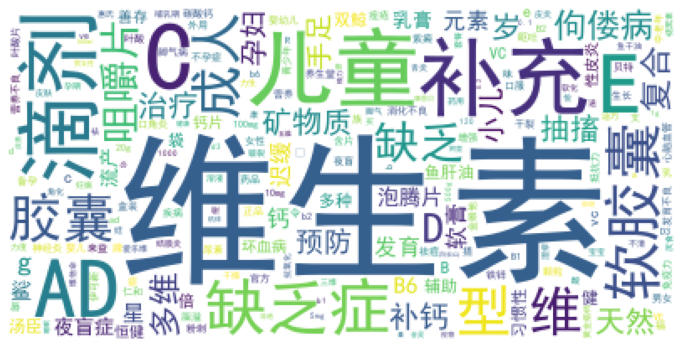

In [61]:
#统计词频并绘制词云
num = pd.Series(list(itertools.chain(*list(data_after)))).value_counts() # 统计词频

wc = WordCloud(font_path='./data/simhei.ttf', background_color='White')
wc2 = wc.fit_words(num)
plt.imshow(wc2)
plt.axis('off')
plt.show()

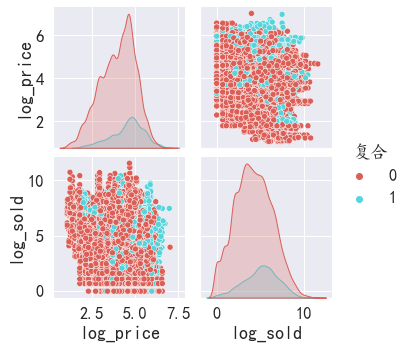

In [62]:
data_1['log_price'] = np.log(data_1['price'])
data_1['log_sold'] = np.log(data_1['sold'])
sns.pairplot(data_1[['log_price','log_sold','复合']],hue='复合',palette='hls')
plt.show()

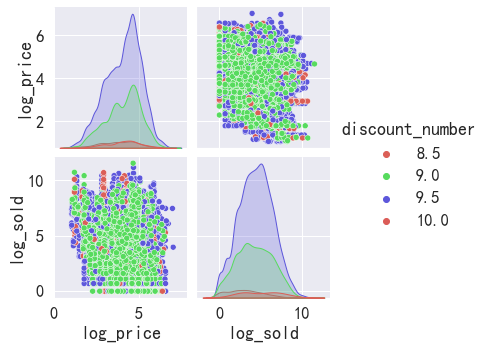

In [63]:
sns.pairplot(data_1[['log_price','log_sold','discount_number']],hue='discount_number',palette='hls')
plt.show()

## 药品分析

In [64]:
len(df.title.unique()) #商品种类数

11258

In [65]:
T = pd.DataFrame(df.groupby('date_time')['title'].unique())

In [66]:
title_number = []
for i in range(T.shape[0]):
    title_number.append(len(T.loc[T.index[i],'title']))
T['title_number'] = title_number

<AxesSubplot:xlabel='date_time'>

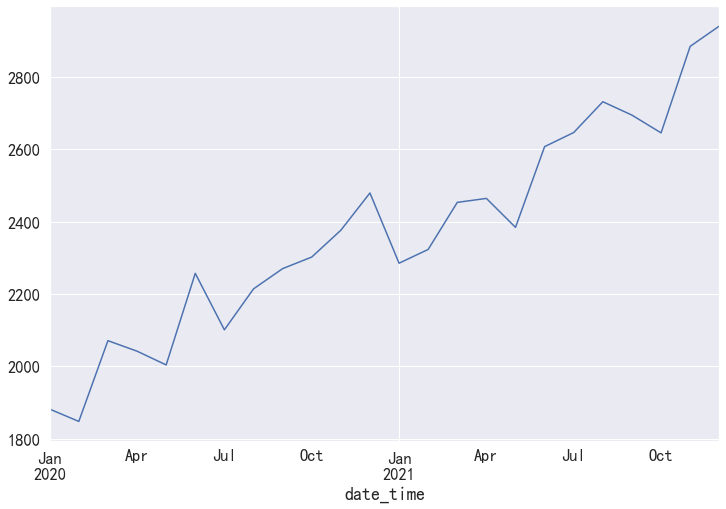

In [67]:
T['title_number'].plot()

In [68]:
#销售额最高的十个药品的销售占比
products = pd.DataFrame(df.groupby(by='title')['sale_total'].sum()).sort_values('sale_total',ascending=False).reset_index()
products['proportion'] = products['sale_total']/sum(products['sale_total'])
products.head(10)

,title,sale_total,proportion
0,领券减】爱乐维复合维生素100片孕妇叶酸补充备孕早期多维元素B,3.569218e+07,0.023788
1,3盒】星鲨维生素D滴剂(胶囊型)24粒补钙维生素D佝偻病官方婴儿钙,2.836576e+07,0.018905
2,Swisse 斯维诗澳洲进口钙片维生素D150片 孕妇VD钙 成人老年补钙,2.248593e+07,0.014987
3,3盒包邮】达因伊可新维生素AD滴剂30粒1岁以上AD预防佝偻病ad滴剂,1.622559e+07,0.010814
4,3盒】星鲨维生素D滴剂(胶囊型)24粒补钙维生素D3佝偻病官方婴儿钙,1.612723e+07,0.010749
5,21金维他多维元素片100片复合维生素B b6 b1 b2维生素c钙铁锌21,1.508954e+07,0.010057
6,达因伊可新维生素AD滴剂50粒0~1岁维生素儿童婴幼儿婴儿钙ad滴剂,1.443055e+07,0.009618
7,100片康恩贝维生素C咀嚼片vc片维他命c含片成人男女高含量维c搭ve,1.396282e+07,0.009306
8,【3盒装】星鲨维生素D滴剂(胶囊型)24粒补钙维生素D 佝偻病,1.279443e+07,0.008527
9,惠氏钙尔奇钙片60片碳酸钙D3孕妇成人补钙维生素D3骨质疏松药店,1.211564e+07,0.008075


In [69]:
data_2 = df[df.title.isin(list(products.head(10).title))]
data_2.head()

,date_time,shop_name,title,sku_name,price,sold,discount_number,sale_total,品类,品牌,厂商,规格,性别,复合,推荐/同款
16,2021-02-01,康恩贝官方旗舰店,100片康恩贝维生素C咀嚼片vc片维他命c含片成人男女高含量维c搭ve,VC1瓶,20.900000,19622,9.0,369089.820000,维生素C咀嚼片（香橙味）,CONBA/康恩贝,华润圣海健康科技有限公司,None,通用,0,0
110,2021-09-01,康恩贝官方旗舰店,100片康恩贝维生素C咀嚼片vc片维他命c含片成人男女高含量维c搭ve,VC1瓶+儿童VC,44.315385,12906,9.0,514740.918462,维生素C咀嚼片（香橙味）,CONBA/康恩贝,华润圣海健康科技有限公司,None,通用,0,0
136,2021-06-01,康恩贝官方旗舰店,100片康恩贝维生素C咀嚼片vc片维他命c含片成人男女高含量维c搭ve,VC1瓶+VE1瓶,75.100000,3747,9.0,253259.730000,维生素C咀嚼片（香橙味）,CONBA/康恩贝,华润圣海健康科技有限公司,None,通用,0,0
140,2021-07-01,阿里健康大药房,3盒包邮】达因伊可新维生素AD滴剂30粒1岁以上AD预防佝偻病ad滴剂,伊可新AD滴剂30粒*3盒(1岁以上),109.000000,5535,9.0,542983.500000,伊可新 维生素AD滴剂（胶囊型）,伊可新,山东达因海洋生物制药股份有限公司,30粒/盒 一岁以上,通用,0,0
218,2021-06-01,阿里健康大药房,达因伊可新维生素AD滴剂50粒0~1岁维生素儿童婴幼儿婴儿钙ad滴剂,【套餐一】本品2盒+2盒锌钙特口服溶液（促进吸收）,179.000000,1939,9.0,312372.900000,伊可新 伊可新 维生素AD滴剂（胶囊型） 50粒/盒,伊可新,山东达因海洋生物制药股份有限公司,50粒/盒,通用,0,0


(-0.5, 399.5, 199.5, -0.5)

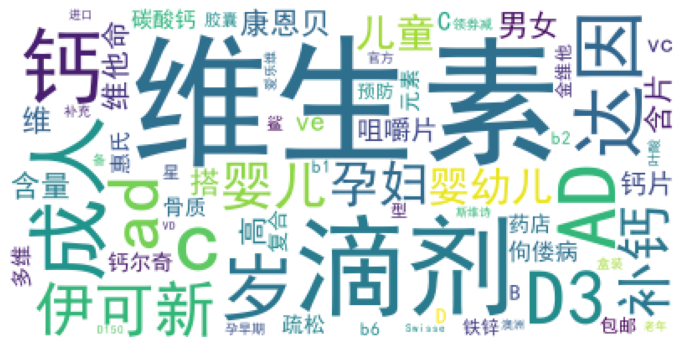

In [70]:
data_cut = data_2['title'].apply(jieba.lcut) # 分词

# 去除停用词
data_after = data_cut.apply(
    lambda x: [i for i in x if i not in stop]
)

#统计词频并绘制词云
num = pd.Series(list(itertools.chain(*list(data_after)))).value_counts() # 统计词频

wc = WordCloud(font_path='./data/simhei.ttf', background_color='White')
wc2 = wc.fit_words(num)
plt.imshow(wc2)
plt.axis('off')
plt.show()

In [71]:
data_2.shape
data_2.shop_name.unique()
data_2.品牌.unique()
data_2.品类.unique()

(265, 15)

array(['康恩贝官方旗舰店', '阿里健康大药房', '天猫国际进口超市', '阿里健康大药房海外店'], dtype=object)

array(['CONBA/康恩贝', '伊可新', '星鲨', '21金维他', 'elevit/爱乐维', 'CALTRATE/钙尔奇',
       'swisse'], dtype=object)

array(['维生素C咀嚼片（香橙味）', '伊可新 维生素AD滴剂（胶囊型）', '伊可新 伊可新 维生素AD滴剂（胶囊型） 50粒/盒',
       '维C咀嚼片', '维生素D滴剂（胶囊型）', '多维元素片(21)', '复合维生素片',
       'CALTRATE/钙尔奇 碳酸钙D3片 0.6g*60片*1瓶/盒', '钙+维生素D'], dtype=object)

In [72]:
data_2_monthly = data_2.drop(['price','sold','discount_number'],axis=1)
data_2_monthly.shape
#相同商品，同月的销售额相加
duplicated = data_2_monthly[data_2_monthly[['date_time','title']].duplicated()==True].reset_index()
duplicated.shape
data_2_monthly = data_2_monthly.drop(data_2_monthly[data_2_monthly[['date_time','title']].duplicated()].index,axis=0)

(265, 12)

(148, 13)

In [73]:
for i in range(148):
    t,d,s = duplicated.title[i],duplicated.date_time[i],duplicated.sale_total[i]
    index = data_2_monthly[(data_2_monthly.title==t)&(data_2_monthly.date_time==d)].index
    data_2_monthly.loc[index,'sale_total'] += s

<AxesSubplot:xlabel='date_time', ylabel='sale_total'>

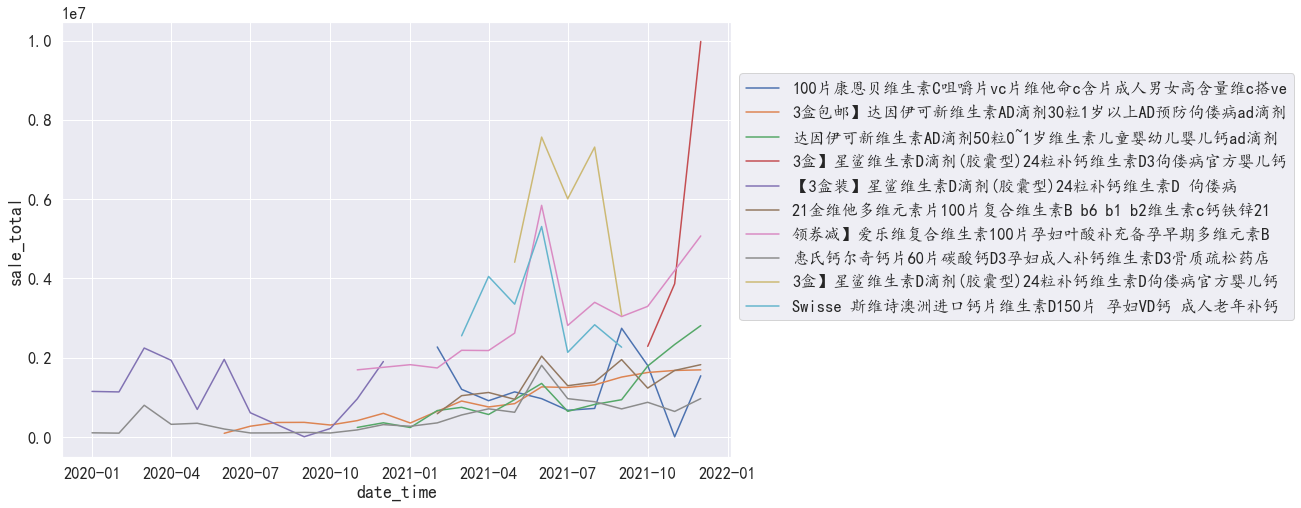

In [74]:
sns.lineplot(x="date_time", y="sale_total",hue='title',  data=data_2_monthly)
plt.legend(loc ='upper left',bbox_to_anchor=(1,0.9))
plt.show()

<AxesSubplot:xlabel='date_time', ylabel='sale_total'>

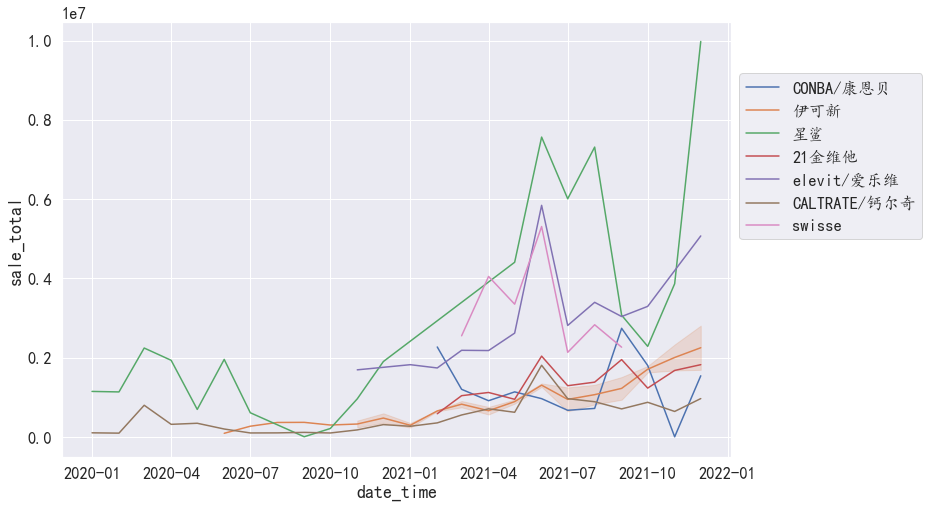

In [75]:
sns.lineplot(x="date_time", y="sale_total",hue='品牌',  data=data_2_monthly)
plt.rcParams['figure.figsize'] = (12.0,8.0)
plt.legend(loc ='upper left',bbox_to_anchor=(1,0.9))
#plt.title('各店铺总销售额占比')
plt.show()

<AxesSubplot:xlabel='date_time', ylabel='sale_total'>

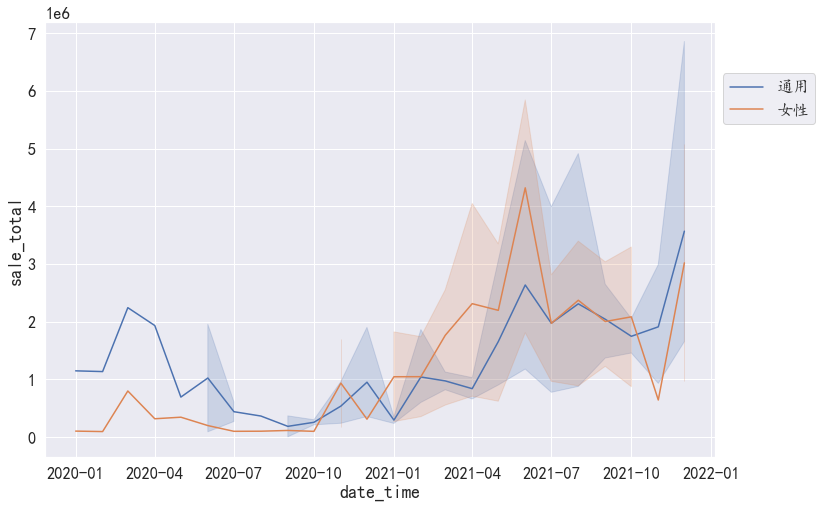

In [76]:
sns.lineplot(x="date_time", y="sale_total",hue='性别',  data=data_2_monthly)
plt.rcParams['figure.figsize'] = (12.0,8.0)
plt.legend(loc ='upper left',bbox_to_anchor=(1,0.9))
#plt.title('各店铺总销售额占比')
plt.show()

## 品牌分析

In [77]:
len(df['品牌'].unique())

515

In [78]:
T = pd.DataFrame(df.groupby('date_time')['品牌'].unique())

In [79]:
brand_number = []
for i in range(T.shape[0]):
    brand_number.append(len(T.loc[T.index[i],'品牌']))

<AxesSubplot:xlabel='date_time'>

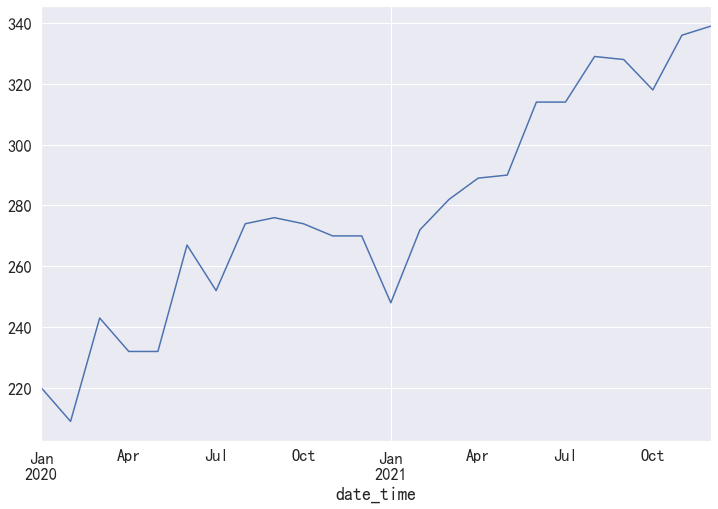

In [80]:
T['brand_number'] = brand_number
T['brand_number'].plot()

In [81]:
#mutual infomation
#Mutual information (non-linear relation)
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [82]:
X = df.copy().drop(['date_time'],axis=1) #计算原数据的MI
y = X.pop('sale_total')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [83]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

price              1.714394
sold               1.440360
title              0.919669
品类                 0.793863
厂商                 0.651862
品牌                 0.629737
shop_name          0.595897
discount_number    0.455715
sku_name           0.389867
规格                 0.220568
复合                 0.040524
性别                 0.040517
推荐/同款              0.005440
Name: MI Scores, dtype: float64

In [84]:
brands = pd.DataFrame(df.groupby(by='品牌')['sale_total'].sum()).sort_values('sale_total',ascending=False).reset_index()
brands['proportion'] = brands['sale_total']/sum(brands['sale_total'])
brands.head(10)

,品牌,sale_total,proportion
0,swisse,2.844053e+08,0.190624
1,CONBA/康恩贝,1.231655e+08,0.082552
2,CENTRUM/善存,1.129509e+08,0.075706
3,elevit/爱乐维,1.008569e+08,0.067600
4,星鲨,9.799816e+07,0.065684
5,汤臣倍健,6.569717e+07,0.044034
6,养生堂,6.017866e+07,0.040335
7,伊可新,5.991355e+07,0.040157
8,FANCL,5.042538e+07,0.033798
9,朗迪,3.281707e+07,0.021996


In [85]:
data_3 = df[df.品牌.isin(list(brands.head(10).品牌))]
data_3.head()

,date_time,shop_name,title,sku_name,price,sold,discount_number,sale_total,品类,品牌,厂商,规格,性别,复合,推荐/同款
1,2020-11-01,天猫国际进口超市,FANCL男40岁综合营养包30包/袋*2复合多种维生素日本芳珂fancl,(【直营】日本FANCL/芳珂 40岁男性综合维生素营养 30袋（30天量）)*2,500.000000,71,9.0,31950.0,综合营养包,FANCL,FANCL株式会社,30包/袋,男性,1,0
4,2021-03-01,阿里健康大药房,买2送礼】elevit/爱乐维复合维生素片140粒维生素缺乏症贫血官方,爱乐维玛咖锌淫羊藿胶囊140粒+爱乐维 复合维生素片30片/盒,371.666667,32,9.0,10704.0,复合维生素片,elevit/爱乐维,拜耳医药保健有限公司,30片/盒,通用,1,0
5,2021-06-01,天猫国际进口超市,FANCL 芳珂日本进口 40岁女性综合营养维生素胶原蛋白保健品 旗舰,NaN,310.000000,159,9.0,44361.0,综合营养包,FANCL,FANCL株式会社,None,女性,1,0
6,2021-10-01,天猫国际妙颜社,【直播推荐】Swisse斯维诗柠檬酸钙+维生素D片150片孕妇中老年钙,NaN,106.000000,471,9.0,44933.4,钙+维生素D,swisse,swisse wellness pty ltd,None,女性,0,1
7,2021-12-01,天猫国际进口超市,【烈儿推荐】美国善存进口复合维生素多维片营养成人女士120女性,(【薇娅推荐】美国善存进口复合维生素多维片营养成人女士120女性)*1,120.000000,98,9.5,11172.0,成年女性复合维生素,CENTRUM/善存,辉瑞生技股份有限公司,None,女性,1,1


In [86]:
data_3 = data_3.drop(['sku_name','厂商','规格'],axis = 1)

In [67]:
data_3.isnull().sum(axis=0)
data_3.shape

date_time              0
shop_name              0
title                  0
sku_name           15257
price                  0
sold                   0
discount_number        0
sale_total             0
品类                   992
品牌                     0
厂商                  2717
规格                 22526
性别                     0
复合                     0
推荐/同款                  0
dtype: int64

(26443, 15)

In [88]:
pd.DataFrame(data_3.groupby(['品牌','shop_name'])['sale_total'].sum()) #不同品牌在不同店铺的销售情况

sale_total
品牌         shop_name                          
CENTRUM/善存 ChemistWarehouse海外旗舰店  1.299970e+06
           hihealth海外专营店          2.236649e+05
           skyshop海外专营店           1.153457e+05
           thejamy保健海外专营店         1.324925e+06
           天猫国际妙颜社                4.153800e+06
...                                        ...
汤臣倍健       焦作国控大药房旗舰店             5.590308e+05
           百康保健品专营店               2.819417e+06
           苏宁易购官方旗舰店              2.411678e+06
           进口/国产保健品精品店            7.210914e+05
           阿里健康大药房                2.633235e+07

[66 rows x 1 columns]

In [89]:
data_3.describe()

,price,sold,discount_number,sale_total,复合,推荐/同款
count,26562.000000,26562.000000,26562.000000,2.656200e+04,26562.000000,26562.000000
mean,131.832255,393.292900,9.215421,3.721138e+04,0.329832,0.013817
std,117.405853,1998.933115,0.357642,2.009261e+05,0.470161,0.116732
min,1.080000,0.000000,8.500000,0.000000e+00,0.000000,0.000000
25%,56.000000,3.000000,9.000000,2.745000e+02,0.000000,0.000000
50%,100.000000,17.000000,9.000000,1.495788e+03,0.000000,0.000000
75%,169.000000,123.000000,9.500000,1.231273e+04,1.000000,0.000000
max,1333.000000,103940.000000,10.000000,9.978240e+06,1.000000,1.000000


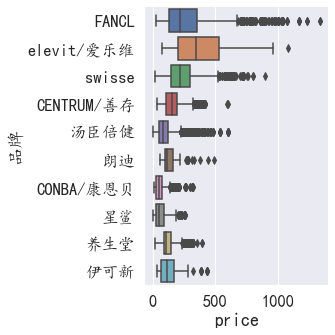

In [90]:
sns.catplot(data=data_3, x="price", y="品牌", kind="box")

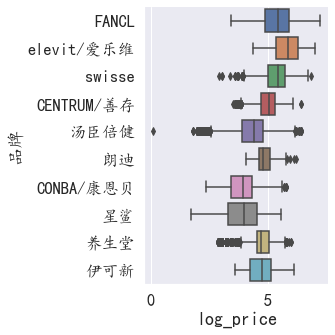

In [91]:
data_3['log_price'] = np.log(data_3['price'])
sns.catplot(data=data_3, x="log_price", y="品牌", kind="box")

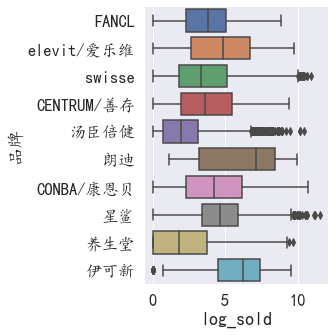

In [92]:
data_3['log_sold'] = np.log(data_3['sold'])
sns.catplot(data=data_3, x="log_sold", y="品牌", kind="box")

In [93]:
X = data_3.copy().drop(['date_time','log_sold'],axis=1)
y = X.pop('sale_total')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [94]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores #data_3中的MI

sold               1.504703
log_price          1.161639
price              1.150162
title              1.014002
品类                 0.846747
shop_name          0.659235
品牌                 0.324248
discount_number    0.284049
复合                 0.067843
性别                 0.059899
推荐/同款              0.004708
Name: MI Scores, dtype: float64

<AxesSubplot:>

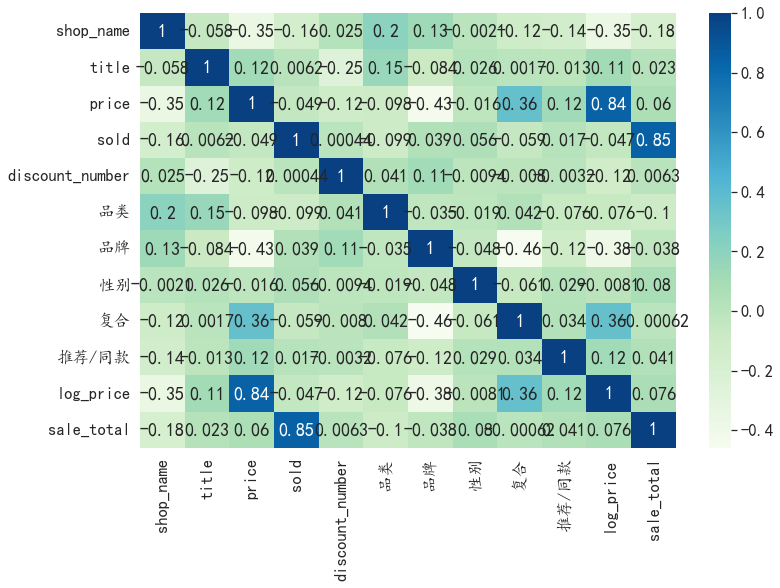

In [95]:
#Linear correlation
X['sale_total'] = y
corr = X.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,annot = True,cmap="GnBu")

In [96]:
data_3.groupby('品牌')['title'].count()

品牌
CENTRUM/善存    3410
CONBA/康恩贝     4414
FANCL         1424
elevit/爱乐维     403
swisse        3229
伊可新            470
养生堂           3049
星鲨            1039
朗迪              92
汤臣倍健          9032
Name: title, dtype: int64

In [97]:
data_3.groupby('品牌')['品类'].count()

品牌
CENTRUM/善存    3285
CONBA/康恩贝     4383
FANCL         1386
elevit/爱乐维     385
swisse        2839
伊可新            470
养生堂           2939
星鲨            1039
朗迪              92
汤臣倍健          8752
Name: 品类, dtype: int64

In [98]:
data_3_monthly = data_3.drop(['price','sold','discount_number'],axis=1)
data_3_monthly.shape
#相同商品，同月的销售额相加
duplicated = data_3_monthly[data_3_monthly[['date_time','品牌']].duplicated()==True].reset_index()
duplicated.shape
data_3_monthly = data_3_monthly.drop(data_3_monthly[data_3_monthly[['date_time','品牌']].duplicated()].index,axis=0)

(26562, 11)

(26324, 12)

In [99]:
for i in range(duplicated.shape[0]):
    t,d,s = duplicated.品牌[i],duplicated.date_time[i],duplicated.sale_total[i]
    index = data_3_monthly[(data_3_monthly.品牌==t)&(data_3_monthly.date_time==d)].index
    data_3_monthly.loc[index,'sale_total'] += s

<AxesSubplot:xlabel='date_time', ylabel='sale_total'>

Text(0.5, 1.0, '各品牌每月总销售额')

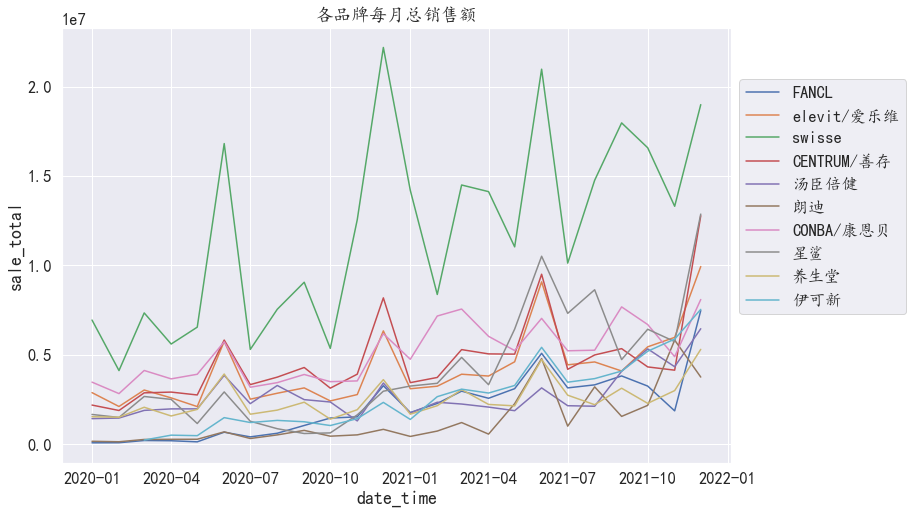

In [100]:
sns.lineplot(x="date_time", y="sale_total",hue='品牌',  data=data_3_monthly)
plt.rcParams['figure.figsize'] = (12.0,8.0)
plt.legend(loc ='upper left',bbox_to_anchor=(1,0.9))
plt.title('各品牌每月总销售额')
plt.show()

## 预测未来三个月的销售额

In [101]:
#create the time series
ts = pd.DataFrame(df.groupby('date_time')['sale_total'].sum())
ts

,sale_total
date_time,
2020-01-01,2.907732e+07
2020-02-01,2.402555e+07
2020-03-01,3.883273e+07
2020-04-01,3.378211e+07
2020-05-01,3.248638e+07
2020-06-01,7.414630e+07
2020-07-01,3.305252e+07
2020-08-01,4.263468e+07
2020-09-01,4.516212e+07


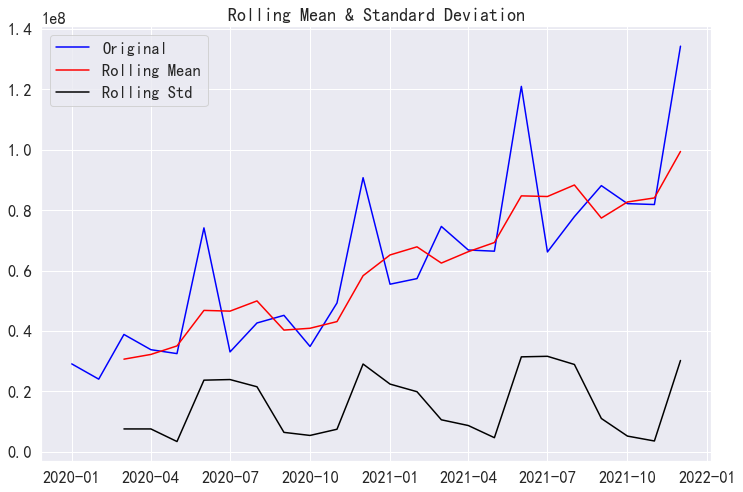

Results of Dickey-Fuller Test:
Test Statistic                 -0.258113
p-value                         0.931231
#Lags Used                      7.000000
Number of Observations Used    16.000000
Critical Value (1%)            -3.924019
Critical Value (5%)            -3.068498
Critical Value (10%)           -2.673893
dtype: float64


In [102]:
#平稳性检验(Dicky-Fuller Test)
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics 
    rolmean=timeseries.rolling(3).mean()
    rolstd=timeseries.rolling(3).std()
    #Plot rolling statistics:
    orig=plt.plot(timeseries,color='blue',label='Original') 
    mean=plt.plot(rolmean,color='red',label='Rolling Mean') #均值
    std=plt.plot(rolstd,color='black',label='Rolling Std') #标准差
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller Test:
    print('Results of Dickey-Fuller Test:')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value 
    print(dfoutput)

#检验结果
test_stationarity(ts)

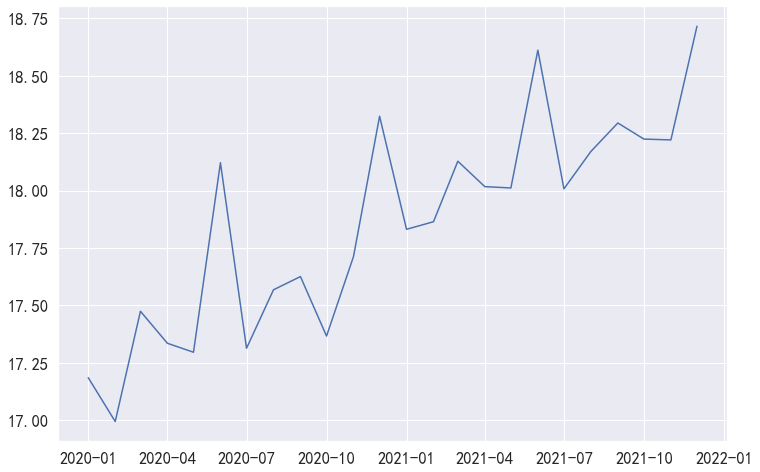

In [103]:
ts_log=np.log(ts)
plt.plot(ts_log)

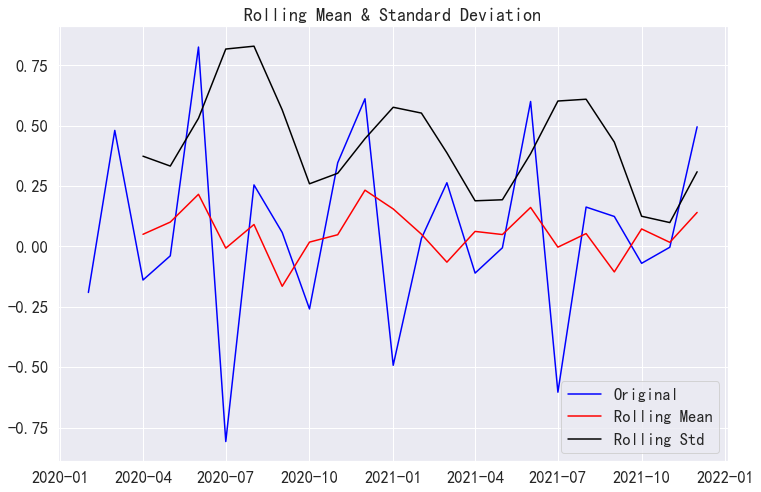

Results of Dickey-Fuller Test:
Test Statistic                -7.008814e+00
p-value                        7.007943e-10
#Lags Used                     4.000000e+00
Number of Observations Used    1.800000e+01
Critical Value (1%)           -3.859073e+00
Critical Value (5%)           -3.042046e+00
Critical Value (10%)          -2.660906e+00
dtype: float64


In [104]:
#Differencing 
ts_log_diff=ts_log-ts_log.shift(1)

# reduced trend considerably
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [105]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(ts_log_diff.sale_total, lags = [i for i in range(1,11)],boxpierce=True)

(array([ 7.05485137,  7.72705993, 13.50818762, 16.65138387, 18.18382612,
        27.66423559, 30.03834772, 30.85660736, 34.21128076, 34.83672661]),
 array([7.90508680e-03, 2.09937614e-02, 3.65710611e-03, 2.25880635e-03,
        2.72462717e-03, 1.08675981e-04, 9.34339905e-05, 1.49002759e-04,
        8.20166903e-05, 1.33133502e-04]),
 array([ 6.20826921,  6.77292439, 11.39782655, 13.7866557 , 14.89001412,
        21.33669256, 22.85612432, 23.3470801 , 25.22569721, 25.55092905]),
 array([0.01271549, 0.03382814, 0.00975817, 0.00800803, 0.01084277,
        0.00159574, 0.00180577, 0.00294608, 0.0027314 , 0.0043935 ]))

一阶差分后数据是平稳的

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

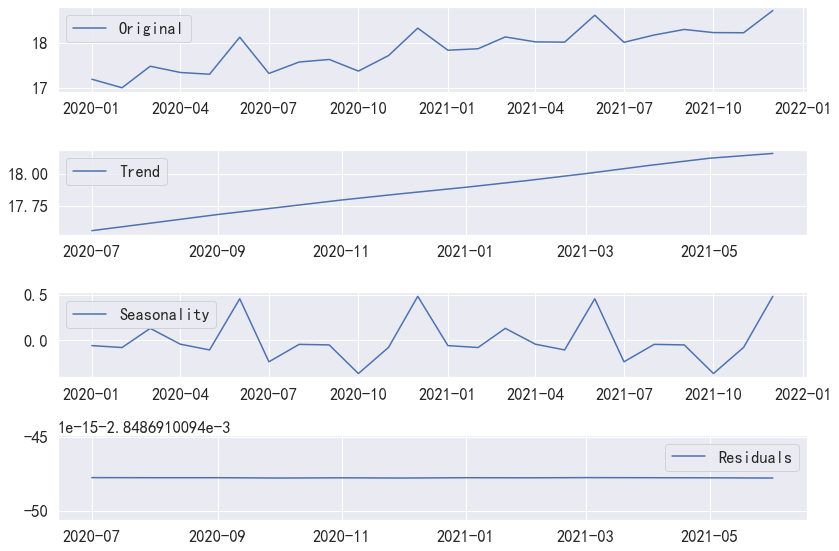

In [106]:
#将趋势和季节性分别建模，并返回序列的其余部分
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
#作图
plt.subplot(411)
plt.plot(ts_log,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

STL代表使用局部加权回归（Loess）进行季节性和趋势性分解。该方法对异常值具有鲁棒性，可以处理任何类型的季节性。

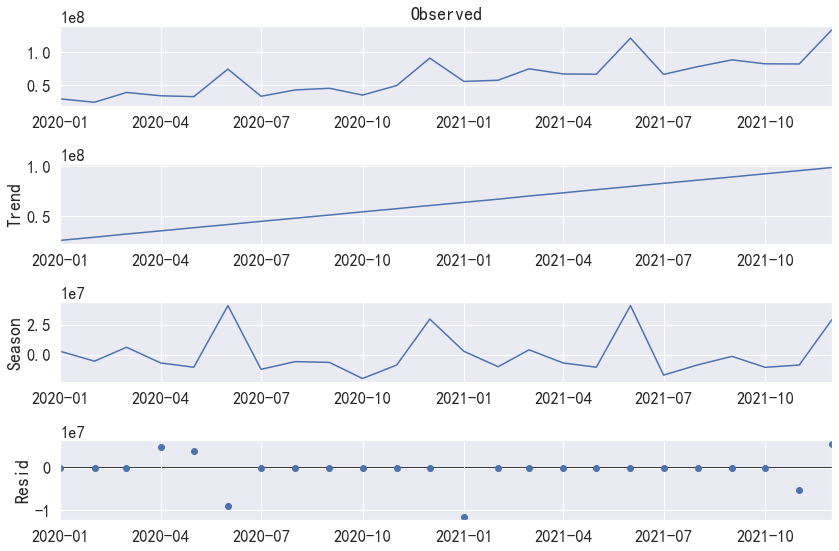

In [107]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts,robust=True)
res_robust = stl.fit()
fig = res_robust.plot()

#### 预测

ARIMA

In [108]:
import statsmodels as sm
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA

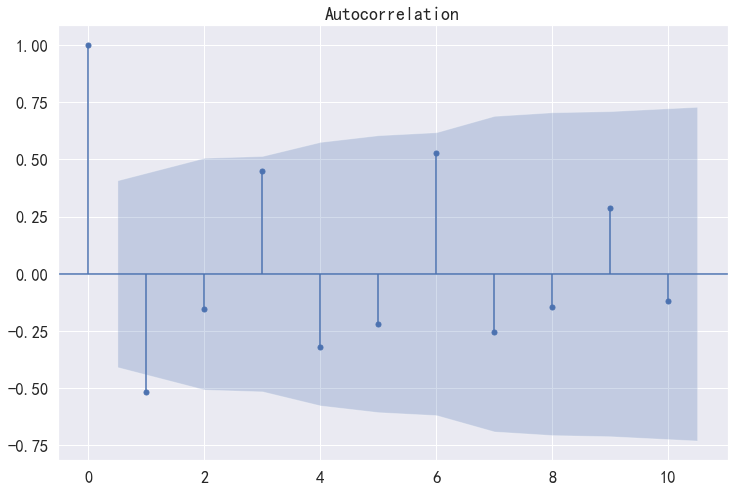

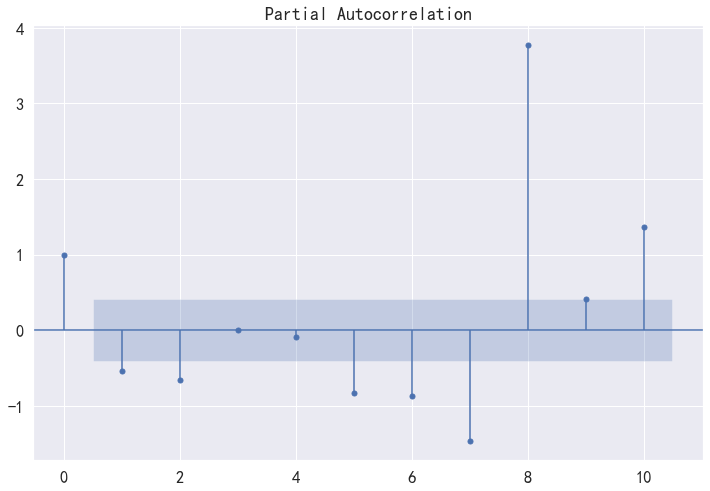

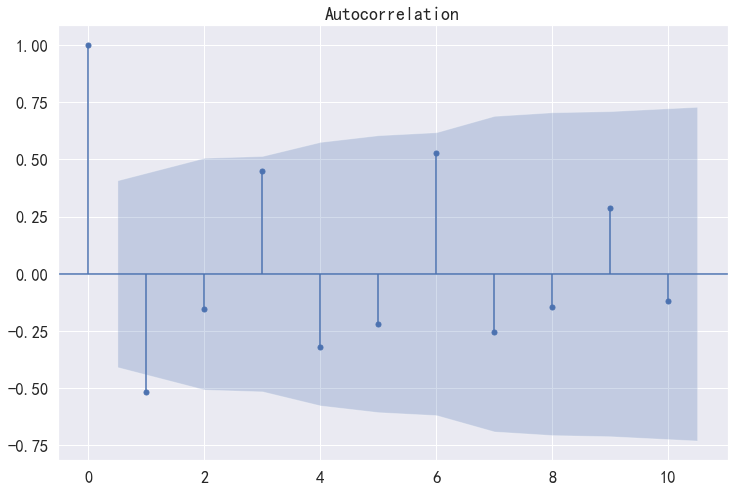

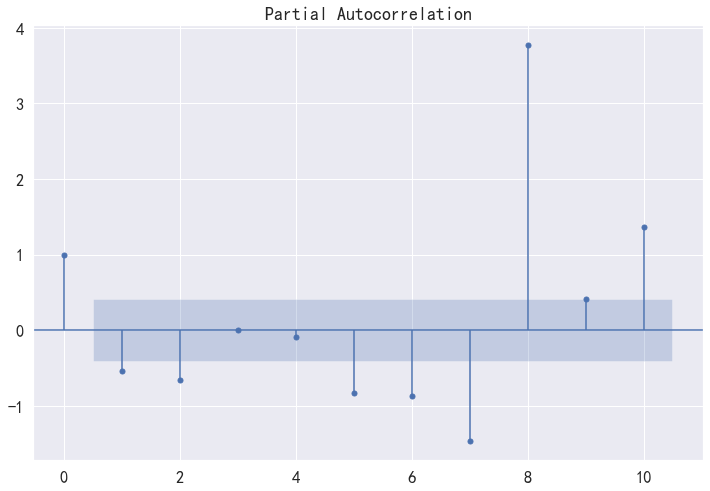

In [109]:
sm.graphics.tsaplots.plot_acf(ts_log_diff,lags=[i for i in range(11)])
sm.graphics.tsaplots.plot_pacf(ts_log_diff,lags=[i for i in range(11)])

In [117]:
p,q=sm.tsa.stattools.arma_order_select_ic(ts_log_diff,max_ar=4,max_ma=4,ic='aic')['aic_min_order']

In [112]:
p,q

(2, 3)

In [116]:
#对比aic和bic
arma_mod20 = ARIMA(ts_log,(2,1,3)).fit()
arma_mod30 = ARIMA(ts_log,(0,1,1)).fit()
arma_mod40 = ARIMA(ts_log,(1,1,1)).fit()
values = [[arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic],[arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic],[arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic]]
df = pd.DataFrame(values,index=["AR(2,1,3)","MA(0,1,1)","ARMA(1,1,1)"],columns=["AIC","BIC","hqic"])
df

,AIC,BIC,hqic
"AR(2,1,3)",4.704743,12.653203,6.703758
"MA(0,1,1)",9.428286,12.834768,10.285007
"ARMA(1,1,1)",9.711025,14.253002,10.853320


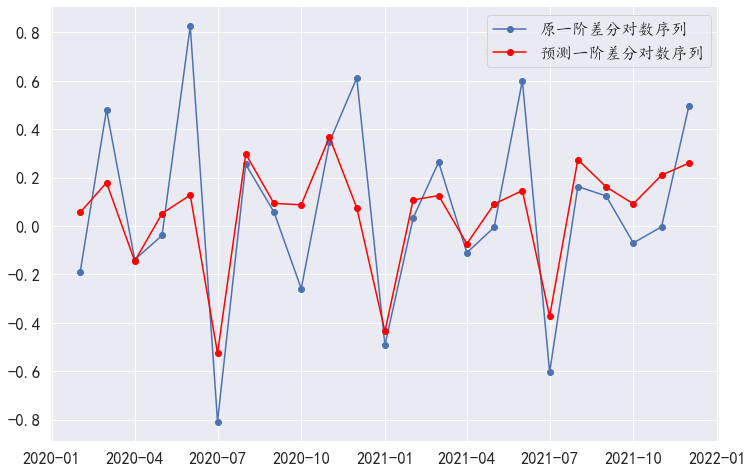

In [118]:
from statsmodels.tsa.arima_model import ARIMA
model_1 = ARIMA(ts_log,order=(0,1,1))
results_ARIMA=model_1.fit()
plt.plot(ts_log_diff,label='原一阶差分对数序列',marker='o')
plt.plot(results_ARIMA.fittedvalues,color='red',label= '预测一阶差分对数序列',marker='o')
plt.legend()

In [119]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.sale_total   No. Observations:                   23
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  -1.714
Method:                       css-mle   S.D. of innovations              0.243
Date:                Fri, 06 Jan 2023   AIC                              9.428
Time:                        23:32:26   BIC                             12.835
Sample:                    02-01-2020   HQIC                            10.285
                         - 12-01-2021                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0556      0.007      7.752      0.000       0.042       0.070
ma.L1.D.sale_total    -1.0000      0.113     -8.828      0.000      -1.222      -0.778
                    

In [120]:
pred = results_ARIMA.fittedvalues.append(results_ARIMA.predict(start='2022-01-01 ',end='2022-03-01',dynamic=True))

In [121]:
prediction_log = pd.DataFrame(pd.Series(pred,copy=True).cumsum()+ts_log['sale_total'][0])
prediction_log.columns=['sale_total']

In [122]:
predictions_ARIMA_diff =pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_diff_cumsum= predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log=pd.Series(ts_log['sale_total'][0],index=ts_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

In [123]:
predictions_ARIMA=np.exp(prediction_log)
predictions_ARIMA.reset_index()['sale_total'][23:26]

23    8.452348e+07
24    8.935725e+07
25    9.446745e+07
Name: sale_total, dtype: float64

预测的销售额为： 23    8.452348e+07
24    8.935725e+07
25    9.446745e+07
Name: sale_total, dtype: float64


Text(0.5, 1.0, 'RMSE: 24049156.5934')

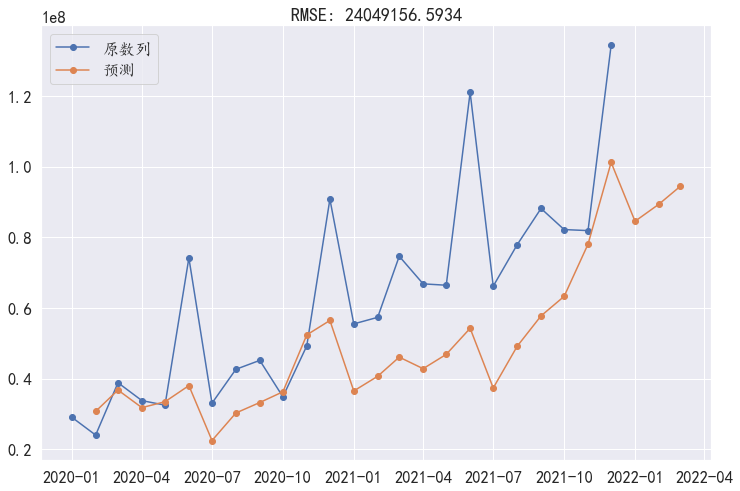

In [124]:
predictions_ARIMA=np.exp(prediction_log)
print('预测的销售额为：',predictions_ARIMA.reset_index()['sale_total'][23:26])
plt.plot(ts,label='原数列',marker='o')
plt.plot(predictions_ARIMA,label='预测',marker='o')
differences = predictions_ARIMA.reset_index().drop([23,24,25],axis=0)['sale_total']-ts.reset_index().drop(0,axis=0).reset_index()['sale_total']
RMSE_1 = np.sqrt(sum((differences)**2)/len(ts))
plt.legend()
plt.title('RMSE: %.4f'% RMSE_1)

Text(0, 0.5, '销售额')

Text(0.5, 0, '月份')

<AxesSubplot:title={'center':'Forecasts from Exponential Smoothing'}, xlabel='月份', ylabel='销售额'>

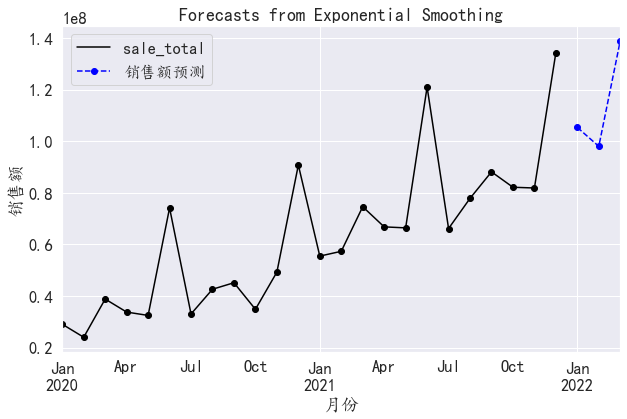

In [125]:
from statsmodels.tsa.api import ExponentialSmoothing
 
EMA_fit = ExponentialSmoothing(ts, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)
fcast3 = EMA_fit.forecast(3)
 
 
ax = ts.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Exponential Smoothing" )
ax.set_ylabel("销售额")
ax.set_xlabel("月份")
 
# For plotting fitted values
# EMA_fit.fittedvalues.plot(ax=ax, style='--', color='red')

EMA_fit.forecast(3).rename('销售额预测').plot(ax=ax, style='--',
 marker='o', color='blue', legend=True)

train linear regression + train XGBoost on residuals

In [126]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

In [127]:
y = ts.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=1,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data


In [128]:
# Test on the last 6  months. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=8, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

LinearRegression(fit_intercept=False)

Text(0.5, 1.0, 'Trends')

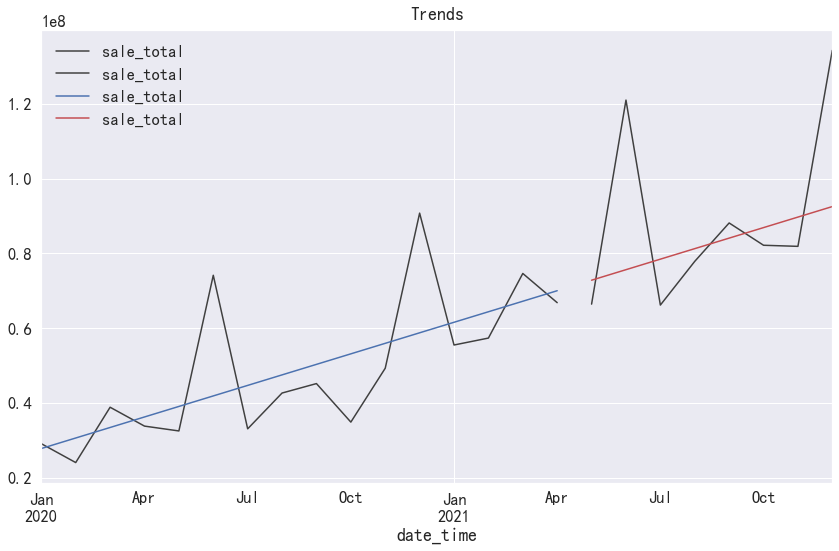

In [134]:
# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

axs = y_train.plot(color='0.25', sharex=True)
axs = y_test.plot(color='0.25', sharex=True, ax=axs)
axs = y_fit.plot(color='C0', sharex=True, ax=axs)
axs = y_pred.plot(color='C3', sharex=True, ax=axs)
plt.title("Trends")

In [135]:
y_fit = np.array(y_fit['sale_total'])
y_pred = np.array(y_pred['sale_total'])

# Create residuals (the collection of detrended series) from the training set
y_resid = np.array(y_train['sale_total']) - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Text(0.5, 1.0, 'Trends')

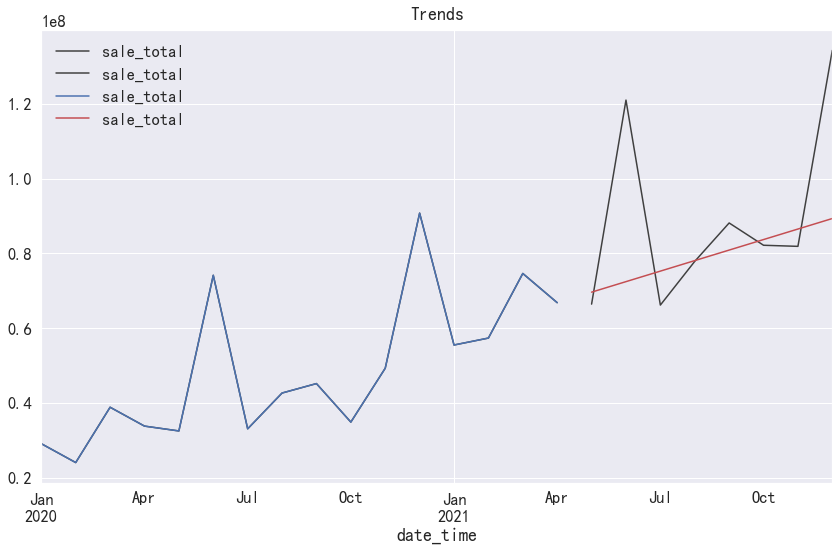

In [136]:
y_fit_boosted = pd.DataFrame(
    y_fit_boosted,
    index=y_train.index,
    columns=y_train.columns,
)
y_pred_boosted = pd.DataFrame(
    y_pred_boosted,
    index=y_test.index,
    columns=y_test.columns,
)

axs = y_train.plot(color='0.25', sharex=True)
axs = y_test.plot(color='0.25', sharex=True, ax=axs)
axs = y_fit_boosted.plot(color='C0', sharex=True, ax=axs)
axs = y_pred_boosted.plot(color='C3', sharex=True, ax=axs)
plt.title("Trends")